In [66]:
import re
import emoji
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [67]:

# Charger les données annotées avec 'commentaire' et 'sentiment' (positif, négatif, neutre)
data=pd.read_csv('C:/Users/Lenovo/Desktop/PFA/code/train_dataset3.csv')


In [68]:
data

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,...,source,retweets,favorites,is_retweet,cleaned_text_textblob,polarity,subjectivity,Sentiment_textBlob,cleaned_text_vader,Sentiment_vader
0,1365695382076854280,Seeji Sundarakshan,Mumbai & Kerala.,"interest in geopolitics, economics, independen...",2016-09-04 09:39:11,608,277,27106,False,2021-02-27 16:08:47,...,Twitter Web App,0,1,False,consolation good number sputnikv instead going...,0.70,0.60,Positive,the only consolation is that good number of sp...,Positive
1,1379853509902934025,Tim Niblett,Burlington ON and Hudson FL,NaN,2011-03-28 20:43:51,88,219,5375,False,2021-04-07 17:48:07,...,Twitter for Android,0,2,False,wife got 2nd moderna shot yesterday florida . ...,0.25,0.25,Positive,my wife and i both got our 2nd moderna shots y...,Positive
2,1446041875815743491,KAS Sub-Saharan Africa,"Berlin, Germany",Official account Sub-Saharan Africa Dept. @KAS...,2021-05-31 14:19:29,312,195,412,False,2021-10-07 09:17:04,...,Twitter Web App,0,3,False,"following author study tom bayes , china prese...",0.00,0.05,Neutral,"following the author of the study tom bayes, c...",Negative
3,1408683429072232448,CowinBangalore,NaN,Follow us to get update as soon as 18 plus vac...,2021-05-17 18:56:45,1102,2,57,False,2021-06-26 07:07:56,...,cowin_vaccine_app,0,0,False,"560011 , age 45 41d1 , 276d2 slot , covaxin 30...",0.00,0.00,Neutral,"560011, age 45 41d1, 276d2 slots, covaxin on 3...",Neutral
4,1410637131131805705,🐝Lisa🐝,Jersey,A happy Bean living in a beautiful island,2009-05-02 15:15:26,41,489,1940,False,2021-07-01 16:31:15,...,Twitter for iPhone,0,0,False,happy 2nd vaccine day ! ! ! moderna,0.40,0.50,Positive,happy 2nd vaccine day to me!!! moderna,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86810,1365360554186072070,James,"Leeds, England",$ocgn #ocgn #dogecoin,2020-06-11 20:27:59,83,359,3943,False,2021-02-26 17:58:17,...,Twitter for iPhone,6,12,False,"ocgn stock smiling_face_with_sunglasses , huge...",0.20,0.95,Positive,ocgn is the stock smiling_face_with_sunglasses...,Positive
86811,1441160179035381762,CGTN,"Beijing, China",CGTN is an international media organization. I...,2013-01-24 03:18:59,13466879,74,167,True,2021-09-23 21:58:56,...,TweetDeck,5,10,False,noted modis visit go current you.s . fda cdc q...,0.00,0.40,Neutral,some have noted modis visit goes against curre...,Neutral
86812,1423247259215405058,CoWIN Blore 18-44,"Bengaluru, India",Get instant alerts for Free/Paid slots in BBMP...,2021-06-29 09:33:13,19,0,1,False,2021-08-05 11:39:23,...,CowinAlertsBot,0,0,False,pincode 560027 covaxin dose 2 50 slot age 18 a...,0.00,0.00,Neutral,pincode 560027 covaxin dose 2 50 slots age 18 ...,Neutral
86813,1415288394859487233,Owl 🦉,NaN,follow for updates on 18-44 vaccination availa...,2021-05-26 19:13:22,147,0,1,False,2021-07-14 12:33:42,...,Cowin Vaccination Availability,0,0,False,"180342 400602 , 16072021 , 61 dose2 highway ho...",0.00,0.00,Neutral,"180342 400602, 16072021, 61 dose2 at highway h...",Neutral


In [69]:
# Assurez-vous que les ressources NLTK sont téléchargées
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


# Obtenir la liste des stop words en anglais
stop_words = set(stopwords.words('english'))




# Mots importants à conserver
mots_importants = {
    "not", "no", "nor", "isn't", "aren't", "wasn't", "weren't", "don't", "doesn't", 
    "didn't", "won't", "wouldn't", "shan't", "can't", "couldn't", "haven't", 
    "hasn't", "hadn't", "mustn't", "mightn't", "needn't", "shouldn't",
    "didn", "doesn", "hadn", "hasn", "haven", "isn", "shan", "wasn", "weren", "won", "wouldn"
}

# Créer une nouvelle liste de stop words en retirant les mots importants
stop_words_personnalises = stop_words - mots_importants

# Fonction de nettoyage du texte
def nettoyer_texte(texte):
    # Conversion des émojis en mots
    texte = emoji.demojize(texte)

    # Conversion en minuscules
    texte = texte.lower()

    # Suppression des liens URL
    texte = re.sub(r'http\S+|www\S+|https\S+', '', texte, flags=re.MULTILINE)

    # Suppression des mentions
    texte = re.sub(r'@\w+', '', texte)

    # Suppression du symbole # et garder le mot après
    texte = re.sub(r'#(\w+)', r'\1', texte)

    # Suppression des espaces supplémentaires
    texte = re.sub(r'\s+', ' ', texte).strip()

    # Garder lettres, chiffres, et les ponctuations importantes: ! ? . ,
    texte = re.sub(r'[^\w\s!?.,]', '', texte)

    # Expansion des contractions
    texte = contractions.fix(texte)

    # Tokenisation
    tokens = word_tokenize(texte)

    # Suppression des stop words personnalisés
    tokens = [mot for mot in tokens if mot not in stop_words_personnalises]

    # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(mot) for mot in tokens]

    # Reconstitution du texte nettoyé
    texte_nettoye = ' '.join(tokens)

    return texte_nettoye



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [70]:
# Exemple d'utilisation
texte_exemple = """
I am very happy with the Service! You can't visit our @gmil site http://example.com
#satisfaction @service 😊👍
"""

texte_nettoyee = nettoyer_texte(texte_exemple)
print(texte_nettoyee)


happy service ! not visit site satisfaction smiling_face_with_smiling_eyesthumbs_up


In [71]:
# Nettoyer les commentaires
data['cleaned_comments'] = data['text'].apply(nettoyer_texte)

In [72]:
data

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,...,retweets,favorites,is_retweet,cleaned_text_textblob,polarity,subjectivity,Sentiment_textBlob,cleaned_text_vader,Sentiment_vader,cleaned_comments
0,1365695382076854280,Seeji Sundarakshan,Mumbai & Kerala.,"interest in geopolitics, economics, independen...",2016-09-04 09:39:11,608,277,27106,False,2021-02-27 16:08:47,...,0,1,False,consolation good number sputnikv instead going...,0.70,0.60,Positive,the only consolation is that good number of sp...,Positive,consolation good number sputnikv instead going...
1,1379853509902934025,Tim Niblett,Burlington ON and Hudson FL,NaN,2011-03-28 20:43:51,88,219,5375,False,2021-04-07 17:48:07,...,0,2,False,wife got 2nd moderna shot yesterday florida . ...,0.25,0.25,Positive,my wife and i both got our 2nd moderna shots y...,Positive,wife got 2nd moderna shot yesterday florida . ...
2,1446041875815743491,KAS Sub-Saharan Africa,"Berlin, Germany",Official account Sub-Saharan Africa Dept. @KAS...,2021-05-31 14:19:29,312,195,412,False,2021-10-07 09:17:04,...,0,3,False,"following author study tom bayes , china prese...",0.00,0.05,Neutral,"following the author of the study tom bayes, c...",Negative,"following author study tom bayes , china prese..."
3,1408683429072232448,CowinBangalore,NaN,Follow us to get update as soon as 18 plus vac...,2021-05-17 18:56:45,1102,2,57,False,2021-06-26 07:07:56,...,0,0,False,"560011 , age 45 41d1 , 276d2 slot , covaxin 30...",0.00,0.00,Neutral,"560011, age 45 41d1, 276d2 slots, covaxin on 3...",Neutral,"560011 , age 45 41d1 , 276d2 slot , covaxin 30..."
4,1410637131131805705,🐝Lisa🐝,Jersey,A happy Bean living in a beautiful island,2009-05-02 15:15:26,41,489,1940,False,2021-07-01 16:31:15,...,0,0,False,happy 2nd vaccine day ! ! ! moderna,0.40,0.50,Positive,happy 2nd vaccine day to me!!! moderna,Positive,happy 2nd vaccine day ! ! ! moderna
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86810,1365360554186072070,James,"Leeds, England",$ocgn #ocgn #dogecoin,2020-06-11 20:27:59,83,359,3943,False,2021-02-26 17:58:17,...,6,12,False,"ocgn stock smiling_face_with_sunglasses , huge...",0.20,0.95,Positive,ocgn is the stock smiling_face_with_sunglasses...,Positive,"ocgn stock smiling_face_with_sunglasses , huge..."
86811,1441160179035381762,CGTN,"Beijing, China",CGTN is an international media organization. I...,2013-01-24 03:18:59,13466879,74,167,True,2021-09-23 21:58:56,...,5,10,False,noted modis visit go current you.s . fda cdc q...,0.00,0.40,Neutral,some have noted modis visit goes against curre...,Neutral,noted modis visit go current you.s . fda cdc q...
86812,1423247259215405058,CoWIN Blore 18-44,"Bengaluru, India",Get instant alerts for Free/Paid slots in BBMP...,2021-06-29 09:33:13,19,0,1,False,2021-08-05 11:39:23,...,0,0,False,pincode 560027 covaxin dose 2 50 slot age 18 a...,0.00,0.00,Neutral,pincode 560027 covaxin dose 2 50 slots age 18 ...,Neutral,pincode 560027 covaxin dose 2 50 slot age 18 a...
86813,1415288394859487233,Owl 🦉,NaN,follow for updates on 18-44 vaccination availa...,2021-05-26 19:13:22,147,0,1,False,2021-07-14 12:33:42,...,0,0,False,"180342 400602 , 16072021 , 61 dose2 highway ho...",0.00,0.00,Neutral,"180342 400602, 16072021, 61 dose2 at highway h...",Neutral,"180342 400602 , 16072021 , 61 dose2 highway ho..."


In [73]:
print(data['cleaned_comments'].str.strip().eq('').sum())  # Vérifiez les chaînes vides


330


In [74]:
# Supprimer les lignes où la colonne 'text' est nulle ou vide
data = data[~data['cleaned_comments'].isnull() & (data['cleaned_comments'].str.strip() != '')]


In [75]:

# Mapping des labels
label_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}


In [76]:


# Diviser en features (X) et labels (y)
X = data['cleaned_comments']
y = data['Sentiment_vader'].map(label_mapping)



In [77]:
X

0        consolation good number sputnikv instead going...
1        wife got 2nd moderna shot yesterday florida . ...
2        following author study tom bayes , china prese...
3        560011 , age 45 41d1 , 276d2 slot , covaxin 30...
4                      happy 2nd vaccine day ! ! ! moderna
                               ...                        
86810    ocgn stock smiling_face_with_sunglasses , huge...
86811    noted modis visit go current you.s . fda cdc q...
86812    pincode 560027 covaxin dose 2 50 slot age 18 a...
86813    180342 400602 , 16072021 , 61 dose2 highway ho...
86814    pincode 560003 covaxin dose 2 20 slot age 18 a...
Name: cleaned_comments, Length: 86485, dtype: object

In [78]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [79]:

# Vectorisation TF-IDF
vectorizer = TfidfVectorizer(stop_words=list(stop_words_personnalises))
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)


In [80]:
# Entraînement du modèle SVM
svm_model = SVC(kernel='linear', C=1.0, random_state=42)  # Ajustez la valeur de C si nécessaire

svm_model.fit(X_train_vectorized, y_train)

# Prédictions sur l'ensemble d'entraînement et de test
y_pred_train = svm_model.predict(X_train_vectorized)
y_pred_test = svm_model.predict(X_test_vectorized)

Train Accuracy: 97.20%
Validation Accuracy: 94.08%

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      5844
           1       0.95      0.97      0.96      5645
           2       0.95      0.94      0.94      5808

    accuracy                           0.94     17297
   macro avg       0.94      0.94      0.94     17297
weighted avg       0.94      0.94      0.94     17297



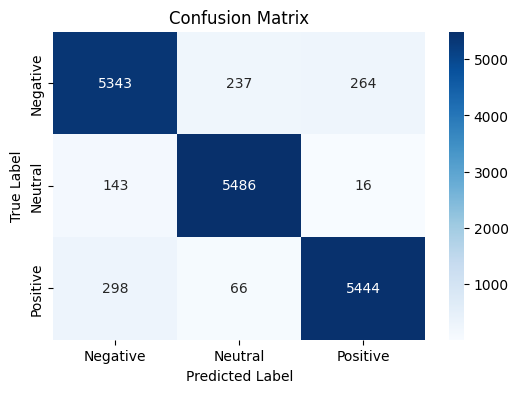

In [81]:
# Calcul de l'accuracy pour l'entraînement et la validation
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)


# Affichage des résultats
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {test_accuracy * 100:.2f}%")

# Évaluation du modèle sur l'ensemble de test
print("\nClassification Report (Validation):")
print(classification_report(y_test, y_pred_test))

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Affichage de la matrice de confusion avec une heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Neutral', 'Positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [113]:
# 10. Afficher la matrice de confusion
conf_matrix = confusion_matrix(sentiment, predictions)
print("\nMatrice de confusion :")
print(conf_matrix)


Matrice de confusion :
[[6709  300  369]
 [ 167 6983   13]
 [ 377   69 6717]]


### tester svm

In [103]:

# Charger les données annotées avec 'commentaire' et 'sentiment' (positif, négatif, neutre)
nouveaux_donnees=pd.read_csv('C:/Users/Lenovo/Desktop/PFA/code/test_dataset3.csv')


In [84]:
nouveaux_donnees

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,...,source,retweets,favorites,is_retweet,cleaned_text_textblob,polarity,subjectivity,Sentiment_textBlob,cleaned_text_vader,Sentiment_vader
0,1379868649431965699,Covid Vaccine Victims,NaN,Documenting side effects and victims of the #C...,2021-04-05 17:03:28,150,73,353,False,2021-04-07 18:48:17,...,Twitter Web App,1,0,False,soldier threatened lose job not take experimen...,0.15625,0.400000,Positive,so now our soldiers are being threatened that ...,Negative
1,1403691682084704262,CowinBangalore,NaN,Follow us to get update as soon as 18 plus vac...,2021-05-17 18:56:45,1146,2,53,False,2021-06-12 12:32:30,...,cowin_vaccine_app,0,0,False,"560040 , age 45 0d1 , 36d2 slot , covaxin 1306...",0.00000,0.000000,Neutral,"560040, age 45 0d1, 36d2 slots, covaxin on 130...",Neutral
2,1370150232453955585,Dirt Simple,NaN,You can't ignore the impact that the blues has...,2018-12-01 02:59:13,266,339,9050,False,2021-03-11 23:10:46,...,Twitter for iPhone,0,0,False,39yearold mother dy 2nd dose moderna vaccine f...,0.00000,0.000000,Neutral,39yearold mother dies after 2nd dose of modern...,Neutral
3,1366252167921770496,rocky cool,NaN,NaN,2016-10-25 07:40:16,0,75,2039,False,2021-03-01 05:01:15,...,Twitter Web App,0,0,False,woke wonderful visuals pm modi getting corona ...,1.00000,1.000000,Positive,woke up to wonderful visuals of pm modi gettin...,Positive
4,1451399755448291334,विमल पाण्डे | Vimal Pandey🇮🇳,भारत,॥ जननी जन्मभूमिश्च स्वर्गादपि गरीयसी ॥ Mother ...,2009-07-10 23:54:05,913,189,7388,False,2021-10-22 04:07:22,...,Twitter for iPhone,0,1,False,thinking_face congress power 1was covaxin covi...,0.00000,1.000000,Neutral,thinking_face had congress been in power then ...,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21699,1410065031501254656,angsumandeka,"Seattle, WA",Travel. Sightsensing. Photography. Triathlon. ...,2019-07-19 08:00:34,45,682,1513,False,2021-06-30 02:37:55,...,Twitter for iPhone,1,1,False,superb news ! covaxin covaxine vaxtowin vaxxed...,1.00000,1.000000,Positive,superb news this ! covaxin covaxine vaxtowin v...,Positive
21700,1376803571291758595,Harsha de Silva,"Colombo, Sri Lanka",Father. Husband. #SriLanka Citizen. MP for Col...,2013-10-18 13:18:06,274206,26,225,True,2021-03-30 07:48:45,...,Twitter for iPhone,14,57,False,association medical specialist issued statemen...,0.00000,0.000000,Neutral,association of medical specialists have issued...,Neutral
21701,1432878456866410496,VaxBLR,"Bengaluru, India",Hourly updates on FREE and PAID 18+ and 45+ va...,2021-06-21 08:44:34,23,0,0,False,2021-09-01 01:30:20,...,VaxBlr,0,0,False,1844 urban bengaluru covidvaccine availability...,0.20000,0.400000,Positive,1844 urban bengaluru covidvaccine availability...,Positive
21702,1420270807205376009,Owl 🦉,NaN,follow for updates on 18-44 vaccination availa...,2021-05-26 19:13:22,175,0,1,False,2021-07-28 06:32:02,...,Cowin Vaccination Availability,0,0,False,"120202 400602 , 01082021 , 37 dose1 tmc p high...",0.00000,0.000000,Neutral,"120202 400602, 01082021, 37 dose1 at tmc p hig...",Neutral


In [104]:
# Étape 1 : Nettoyer les nouveaux commentaires
nouveaux_donnees['cleaned_comments'] = nouveaux_donnees['text'].apply(nettoyer_texte)


In [105]:
# Étape 2 : Vectoriser les nouveaux commentaires avec le même vectoriseur
nouveaux_donnees_vectorized = vectorizer.transform(nouveaux_donnees['cleaned_comments'])


In [106]:
# Étape 3 : Prédire les classes pour les nouveaux commentaires
predictions = svm_model.predict(nouveaux_donnees_vectorized)

# Mapping des labels pour l'affichage
reverse_label_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

# # Afficher les résultats
# for text, pred in zip(nouveaux_donnees['text'], predictions):
#     sentiment = reverse_label_mapping[pred]
#     print(f"Texte : '{text}' -> Prédiction : {sentiment}")


In [107]:
predictions

array([0, 1, 1, ..., 2, 1, 0], dtype=int64)

In [108]:

# Mapping des labels
label_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
sentiment=nouveaux_donnees['Sentiment_vader'].map(label_mapping)

In [109]:
sentiment

0        0
1        1
2        1
3        2
4        1
        ..
21699    2
21700    1
21701    2
21702    1
21703    2
Name: Sentiment_vader, Length: 21704, dtype: int64

In [110]:
# Étape 4 : Calculer l'accuracy
accuracy = accuracy_score(sentiment, predictions)
print(f"\nAccuracy sur l'ensemble de test : {accuracy * 100:.2f}%")


Accuracy sur l'ensemble de test : 94.03%


In [111]:
# 10. Afficher la matrice de confusion
conf_matrix = confusion_matrix(sentiment, predictions)
print("\nMatrice de confusion :")
print(conf_matrix)



Matrice de confusion :
[[6709  300  369]
 [ 167 6983   13]
 [ 377   69 6717]]


In [112]:
# 11. Afficher le rapport de classification
print("\nRapport de classification :")
print(classification_report(sentiment, predictions))


Rapport de classification :
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      7378
           1       0.95      0.97      0.96      7163
           2       0.95      0.94      0.94      7163

    accuracy                           0.94     21704
   macro avg       0.94      0.94      0.94     21704
weighted avg       0.94      0.94      0.94     21704

